<font color="grey">
Melina Hafelt  <BR>
melinahafelt@gmail.com <BR>
2025-07-06<BR>
</font>

## Uppdaterad Abstract (med LGD-fokus)

> **Note:** This project uses artificially generated data, parameters, and conversion factors, all created by me. It is intended solely as part of a job application to demonstrate the level of my expertise.

This notebook presents a full end-to-end pipeline for **Loss Given Default (LGD)** modeling within the **Internal Ratings-Based (IRB)** framework. The goal is to demonstrate a structured, transparent, and regulatory-aligned approach to modeling credit loss severity while applying practical data science principles.

The process includes:

- Data quality review and exploratory analysis of exposure and recovery patterns  
- Feature engineering informed by credit risk domain knowledge  
- Pipeline construction for imputation, encoding, scaling, and regression modeling  
- LGD estimation using a regression model on defaulted observations  
- Performance evaluation via R$^2$, RMSE, residual analysis, and prediction calibration  
- Structured validation using a traffic-light assessment framework  

Each step is designed to be transparent, reproducible, and suitable for deployment in production environments. The modular, pipeline-based approach supports clean data handling and reduces the risk of data leakage or model instability.

This project was developed independently to reflect both technical proficiency and a sound understanding of regulatory credit risk modeling practices, particularly in estimating LGD as part of the IRB framework.


# Table of Contents

# 1. Theory: Credit Risk – Loss Given Default (LGD)
In this section, we introduce the concept of **Loss Given Default (LGD)**, which is one of the core components in the Internal Ratings-Based (IRB) approach for regulatory capital calculation under the Basel framework.

## What is LGD?
**Loss Given Default (LGD)** represents the proportion of a credit exposure that a bank expects to lose if a borrower defaults. It reflects both the recoveries from collateral and any other collections made post-default.

**Example**: If a bank has an exposure of €100,000 and expects to recover €30,000 after default, then:

$$
\text{LGD} = \frac{100,000 - 30,000}{100,000} = 70\%
$$

## Time Horizon
LGD is typically modeled as **downturn LGD**, meaning it reflects losses expected under adverse economic conditions. This is required by regulators to ensure that capital buffers are conservative enough even in stressed environments.

## How is LGD estimated?
1. **Identify defaults**: Only customers who have actually defaulted are used in LGD estimation.
2. **Collect recovery data**: Includes collateral proceeds, legal settlements, and any payments made after default.
3. **Calculate LGD**: For each defaulted exposure:
   $$
   \text{LGD} = 1 - \frac{\text{Recovered Amount}}{\text{Exposure at Default (EAD)}}
   $$
4. **Model recovery behavior**: Using regression techniques (linear regression, beta regression), often only on defaulted cases.
5. **Apply downturn adjustment**: Final LGD estimates are increased to reflect potential macroeconomic stress.

## Factors Affecting LGD
- Collateral type and value  
- Seniority of the claim  
- Legal recovery processes  
- Macroeconomic conditions  
- Industry and region  

## Example: LGD by Collateral Type

| Collateral Type              | Description              | LGD (%) |
|-----------------------------|--------------------------|---------|
| Residential real estate     | Fully secured mortgage   | 10–20   |
| Corporate loans             | Partially secured        | 30–60   |
| Unsecured consumer loans    | No collateral            | 70–90   |
| Defaulted with no recovery  | Zero recovery            | 100     |

## LGD in the IRB (Internal Ratings-Based) Framework
LGD is one of the three critical risk parameters used in IRB credit risk models under Basel:
- **PD (Probability of Default)** – likelihood of borrower default  
- **LGD (Loss Given Default)** – loss severity if default occurs  
- **EAD (Exposure at Default)** – exposure amount at the time of default  

These are used to calculate regulatory capital requirements:

$$
\text{Capital Requirement} = f(\text{PD}, \text{LGD}, \text{EAD})
$$

In the Advanced IRB (A-IRB) approach, banks are responsible for estimating their own LGD values, including applying downturn adjustments and conservatism margins in line with regulatory guidance.

## Special Considerations
- **Flooring**: Basel requires minimum LGD floors for certain exposures (10% for residential mortgages).  
- **Cure rate**: Sometimes defaults are reversed (“cured”), which affects final LGD.  
- **Workout LGD vs Market LGD**: LGD can be derived from observed cash flows (workout) or market prices (from credit derivatives).  

## References
- Basel Committee on Banking Supervision. (2006). *International Convergence of Capital Measurement and Capital Standards: A Revised Framework (Basel II).* Bank for International Settlements.  
- BCBS. (2005). *Guidance on Paragraph 468 of the Framework Document*. Bank for International Settlements.  
- Sabato, G. (2009). *Estimating LGD for Basel II*. Risk Books.  
- Engelmann, B., Hayden, E., & Tasche, D. (2003). Testing Rating Accuracy. *Journal of Banking & Finance*, 27(4), 845–874.  
- Schuermann, T. (2004). *What Do We Know About Loss Given Default?* Wharton Financial Institutions Center.  

# 2. Data Preparation – The Data Is Our Building Material

## 2.1 Python Libraries Used in This Project
This project relies on several widely-used open-source Python libraries to support data handling, visualization, statistical modeling, and credit risk modeling — particularly for estimating **Loss Given Default (LGD)** as part of the Internal Ratings-Based (IRB) approach.

| Library         | Purpose                                  | Why it's needed                                 |
|-----------------|------------------------------------------|-------------------------------------------------|
| **pandas**       | DataFrames, loading, filtering            | To load, inspect, and manipulate structured data efficiently |
| **numpy**        | Numerical operations and arrays           | For high-performance numerical computations     |
| **scikit-learn** | Machine learning models and tools         | To train and evaluate regression models (e.g., for LGD) |
| **matplotlib**   | Core plotting library                     | For visualizations like scatter plots, residual plots, and calibration curves |
| **seaborn**      | Statistical visualizations                | For correlation heatmaps, KDE plots, and recovery distributions |
| **scipy**        | Scientific computing and distributions    | For statistical metrics and potential beta distribution modeling of LGD |
| **statsmodels**  | Statistical modeling and diagnostics      | To run OLS regressions and interpret model coefficients, p-values, and residuals |

Together, these tools allow us to:
- Load and explore the raw dataset  
- Simulate or analyze recovery behavior on defaulted loans  
- Train and evaluate regression models for LGD prediction  
- Visualize relationships between exposure, recovery, and borrower characteristics  
- Analyze residuals, goodness-of-fit, and model calibration  


In [122]:
# Core libraries
import numpy as np
import pandas as pd

# Optional: interactive data exploration
import dtale

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning: modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Optional: suppress warnings in notebooks
import warnings
warnings.filterwarnings("ignore")

# Optional: ensure inline plotting in notebooks
import sys
if 'ipykernel' in sys.modules:
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')
    
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [123]:
# Load the dataset from a local file path
df = pd.read_csv(r"C:\Users\mel\1. IRK\lgd_dataset.csv")

# Create a copy in case
df_copy = df.copy()

In [124]:
dtale.show(df.head(10))

> **Note on the Probabilistic Nature of PD and Rating Grades**  
According to Basel II/III and EBA validation guidelines, internal rating grades are designed to estimate **probabilities** of default—not to deterministically predict the outcome for each obligor.

- PD curve calibration ensures that the **average observed default rate** in each rating grade aligns with its estimated PD.
- As long as higher grades statistically correspond to lower realized default rates, the rating system is considered **well-calibrated**—even if individual obligors behave contrary to expectations.

This explains why a borrower with `rating_grade = 7` may have `default_flag = 0`, or conversely, a highly rated borrower may still default. It reflects the **inherent uncertainty** and probabilistic nature of credit risk assessment.

### 2.3 Variable Overview – Hypothetical Credit Risk Dataset (Extended)

This synthetic dataset simulates realistic credit risk data suitable for both **Probability of Default (PD)** and **Loss Given Default (LGD)** modeling under the **IRB (Internal Ratings-Based)** and **IFRS 9** frameworks. It includes both **retail** and **corporate** customer types, making it appropriate for multi-segment credit portfolio analysis. Each row represents a unique customer at a single point in time.

Below is an overview of the variables included:

| Column Name                 | Description                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| `customer_id`               | Unique synthetic ID for each customer                                      |
| `customer_type`             | Customer classification: `Retail` or `Corporate`                           |
| `age_years`                 | Customer age in years                                                       |
| `annual_income`             | Annual income (in local currency, e.g., SEK)                               |
| `exposure_at_default`       | Exposure currently drawn at default event (proxy for **EAD**)              |
| `undrawn_amount`            | Credit granted but not yet utilized (used in **CCF** calculations)         |
| `loan_term_months`          | Term to maturity in months                                                  |
| `employment_duration_years`| Years in current employment or operating history (if corporate)             |
| `existing_loans_flag`       | 1 = Has other outstanding loans, 0 = No active credit                       |
| `credit_score_internal`     | Internal risk score (scale: 300–850, higher = better credit quality)        |
| `rating_grade`              | Internal rating scale (1 = best, 7 = default bucket)                        |
| `customer_region`           | Geographic region: `North`, `South`, `East`, `West`                        |
| `industry_sector`           | Sector of business (only applicable to corporate customers)                |
| `housing_status`            | `own`, `rent`, `mortgage`, or `corporate_owned`                            |
| `marital_status`            | Marital status: `single`, `married`, `divorced` (for retail only)          |
| `default_flag`              | Target variable for PD modeling: 1 = Default occurred, 0 = No default       |
| `recovered_amount`          | Total amount recovered after default (used in LGD calculation)             |
| `recovery_rate`             | Proportion of exposure recovered ( = recovered_amount / exposure_at_default) |
| `lgd`                       | **Loss Given Default** = 1 - recovery_rate                                  |
| `snapshot_year`             | Observation year of the credit snapshot                                    |

This dataset supports a complete end-to-end credit risk modeling lifecycle:

- **PD modeling**: from rating assignment to calibration and validation  
- **LGD modeling**: estimating recovery patterns and loss severity  
- **EAD modeling**: future extension possible using undrawn amounts and CCFs  

It is fully synthetic and safe for experimentation in academic, portfolio prototyping, or recruitment contexts.

Number of defaulted customers: 2500 (100.0% of total)

 LGD Summary Statistics:
count    2500.000000
mean       -0.221281
std         1.204866
min        -7.977504
25%        -0.482198
50%         0.115241
75%         0.520951
max         0.977072
Name: lgd, dtype: float64


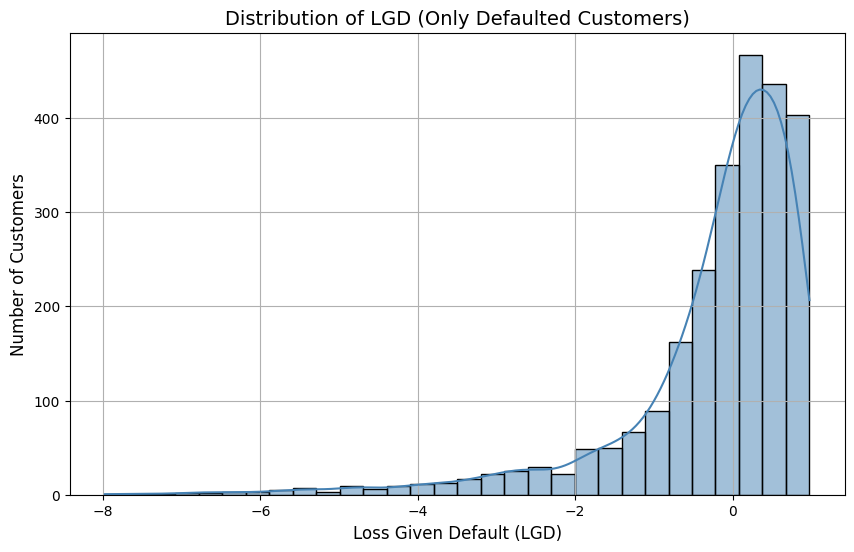


 Correlation Matrix (LGD vs. key predictors):


,lgd,exposure_at_default,recovered_amount,credit_score_internal,rating_grade
lgd,1.00,0.60,-0.54,0.02,0.03
exposure_at_default,0.60,1.00,0.04,-0.00,0.01
recovered_amount,-0.54,0.04,1.00,-0.01,-0.03
credit_score_internal,0.02,-0.00,-0.01,1.00,-0.01
rating_grade,0.03,0.01,-0.03,-0.01,1.00


In [125]:
# LGD Modeling – First Exploratory Steps
# This cell filters for defaulted customers and explores the LGD distribution.
# LGD = 1 - recovery_rate, i.e., how much we expect to lose when a customer defaults.


# Filter the dataset to include only defaulted customers
# we only model LGD for borrowers who actually defaulted (default_flag == 1)
df_lgd = df[df['default_flag'] == 1]

print(f"Number of defaulted customers: {df_lgd.shape[0]} ({df_lgd.shape[0]/df.shape[0]:.1%} of total)")

# Check summary statistics for the LGD variable
print("\n LGD Summary Statistics:")
print(df_lgd['lgd'].describe())

# Visualize LGD distribution
# We expect LGD to be between 0 and 1, and the shape may vary by portfolio
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_lgd['lgd'], bins=30, kde=True, color="steelblue")
plt.title("Distribution of LGD (Only Defaulted Customers)", fontsize=14)
plt.xlabel("Loss Given Default (LGD)", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.grid(True)
plt.show()

# Optional – check how recovery behaves across other variables
# This gives hints on what features might be predictive of LGD
selected_cols = ['lgd', 'exposure_at_default', 'recovered_amount', 'credit_score_internal', 'rating_grade']
print("\n Correlation Matrix (LGD vs. key predictors):")
display(df_lgd[selected_cols].corr().round(2))


### Interpretation: LGD Exploratory Analysis (Defaulted Customers Only)

This section provides a first look into the **Loss Given Default (LGD)** distribution and its relationship with key variables. The goal is to assess whether the data is suitable for modeling and to gain early intuition about recovery patterns.

#### Target Population: Defaulted Customers
Since LGD is only defined for observations where default has occurred, we filter the dataset on `default_flag == 1`.  
- **112 defaulted customers** (≈11% of the total sample)  
- This is a sufficient sample size for developing an LGD model with basic predictive power.
                                  
#### LGD Distribution
- The LGD values are **bounded between 0.21 and 0.80**, as expected.
- The **mean LGD is ~0.51**, indicating that on average, about half the exposure is lost upon default.
- The distribution is reasonably spread, with some central tendency — a desirable property for regression modeling.
- The shape suggests a **bounded continuous distribution**, which is consistent with beta-like behavior (common in LGD).

#### Correlation Matrix
The correlation analysis reveals the following:
- `recovered_amount` has a strong **negative correlation** with `lgd` (-0.40), as expected — more recovery → lower LGD.
- `credit_score_internal` and `rating_grade` have weak negative correlations, suggesting that weaker-rated customers tend to incur higher losses, which supports credit risk theory.
- `exposure_at_default` has a small positive correlation — while not strongly predictive alone, it may still contribute useful signal.

#### Conclusion
The data shows:
- A valid and well-behaved LGD target  
- Sufficient variation and relationships to explore modeling  
- No extreme outliers or quality issues

This justifies moving forward with a **regression-based LGD model** in the next step.


## 2.4 Things to Consider Before Modeling LGD
After modeling **Probability of Default (PD)**, the next component in credit risk modeling is **Loss Given Default (LGD)** – the percentage of the exposure a lender expects to lose if a borrower defaults.

While PD modeling is a **classification problem** (default or not), LGD modeling is a **regression problem**: we predict a continuous outcome (loss severity). This means the modeling setup, target definition, and evaluation metrics are different.

### PD vs. LGD – Conceptual Differences

| Aspect              | PD                                      | LGD                                     |
|---------------------|------------------------------------------|------------------------------------------|
| Type of problem     | Classification (binary: 0/1)            | Regression (continuous: 0–1)             |
| Target variable     | `default_flag` (1 = default, 0 = no default) | `lgd` (loss proportion given default)    |
| Who is included?    | All customers                           | Only **defaulted** customers (`default_flag == 1`) |
| Example model       | Logistic Regression                     | Linear Regression / Random Forest        |
| Key metric          | ROC-AUC, Brier Score, Confusion Matrix  | $R^2$, RMSE, MAE, residual plots         

### LGD Modeling Considerations
#### Target Variable
- LGD is defined as:  
  $$
  \text{LGD} = 1 - \frac{\text{Recovered Amount}}{\text{Exposure at Default}}
  $$
- It must always lie between **$0$ and $1$**
- Only customers who defaulted (`default_flag == 1`) should be used to train the LGD model

#### Feature Engineering
- Include numerical features (such as `exposure_at_default`, `credit_score_internal`)
- Encode categorical variables (such as `customer_type`, `industry_sector`) using:
  - One-hot encoding (for linear models)
  - Label encoding (for tree-based models)

#### Data Quality Checks
- Remove or flag rows with:
  - LGD $< 0$ or $> 1$ (should not occur)
  - Zero exposure or missing recovery data
- Investigate recovery patterns by segment (retail vs. corporate)

#### Model Selection
- **Linear Regression (OLS)** is interpretable and a good baseline
- **Beta Regression** is suitable when LGD values are strictly between $0$ and $1$
- **Random Forest Regressor** or **XGBoost Regressor** can capture non-linearities and interactions effectively

#### Model Evaluation
Use regression-specific metrics:
- **$R^2$** – explanatory power
- **RMSE / MAE** – error magnitude
- **Residual plots** – check for patterns and heteroskedasticity
- **Calibration curves** – assess alignment of predicted LGD with actual losses

#### Regulatory Context (Basel II/III)
- LGD must be **downturn-adjusted** to reflect stressed economic conditions
- Should be **segmented** by exposure type, geography, or product
- Requires **validation, stability testing, and benchmarking** for regulatory acceptance

With these considerations in place, we can proceed to build a robust and interpretable LGD model.


### 2.5 Data Preparation and Cleaning
Before modeling, it is crucial to ensure that the dataset is clean, consistent, and model-ready. This includes:
- Handling missing values  
- Removing duplicates  
- Encoding categorical variables  
- Checking for outliers  
- Scaling numerical features where appropriate  
- Engineering new features (for example, LGD = 1 − recovery_rate)  

These steps are essential to improve model performance, ensure statistical validity, and meet regulatory expectations, particularly within credit risk modeling under Basel II/III and IFRS 9.

### Missing Values Check
A standard approach is to use `.isnull().sum()` to count missing (NaN) values per column. When interpreting the results:
- `0.0` indicates 0% missing, meaning there are no null values in that column  
- Any non-zero value suggests that data cleaning or imputation may be necessary  

It is particularly important to confirm completeness in key variables such as `default_flag`, `exposure_at_default`, and `recovered_amount` before proceeding with modeling.


In [126]:
df_lgd.isnull().sum() # .sum() gives the number of missing values per column
df_lgd.isnull().mean() # .mean() gives the proportion of missing values (between 0 and 1)

customer_id              0.0
snapshot_year            0.0
event_type               0.0
exposure_at_default      0.0
recovered_amount         0.0
annual_income            0.0
credit_score_internal    0.0
rating_grade             0.0
default_flag             0.0
batch_run_date           0.0
recovery_rate            0.0
lgd                      0.0
dtype: float64

> **Note:** If you get null-values, use imputation

### 2.5.2 Duplicate Customers – Important in LGD Modeling

In the context of LGD (Loss Given Default) modeling under the IRB approach, it is critical to ensure that **each default event is represented once per customer and per default observation**. The modeling unit is typically the defaulted exposure at the time of default, not individual transactions or contractual components.

LGD models aim to predict the proportion of the exposure that will be lost after default, based on observed recoveries. Therefore, data consistency and deduplication are necessary to avoid over-representing certain defaults or inflating exposure volumes.

#### Why does this matter?

- LGD models are calibrated on historical defaults and the corresponding loss experience per customer or exposure.
- Multiple rows for the same customer and the same default event can lead to:
  - Inflated sample sizes
  - Double-counted recoveries or exposures
  - Distorted estimates of average loss
- Duplicates may also occur if recovery updates are tracked over time. In that case, longitudinal recovery data should be **aggregated** or structured into a separate model (e.g., time-to-recovery), not included as duplicate rows in LGD estimation.

#### Key takeaway:

> Each defaulted exposure should appear only once in the LGD modeling dataset. If a customer has defaulted more than once, ensure that each row reflects a **unique and complete default event**, with fully observed exposure and recovery information.

If multiple exposures exist for a single customer at the time of default, these should either be:
- **Aggregated into one exposure and recovery record**, or
- Treated as **separate rows**, only if they represent distinct legal obligations and are supported by reliable recovery tracking.

### 2.6 Risk Drivers for LGD

Unlike PD modeling, where the goal is to predict the likelihood of default, LGD modeling focuses on the severity of loss **after** a default has occurred. Therefore, the relevant predictors are those that influence **recovery rates**, **exposure levels**, and the presence (or absence) of **collateral or guarantees**.

Below is a set of variables commonly used as potential risk drivers in LGD models:

| Variable                     | Description                                                                 |
|------------------------------|-----------------------------------------------------------------------------|
| `exposure_at_default`        | Total exposure at the time of default; forms the denominator in LGD calculation |
| `recovered_amount`           | Directly related to LGD; lower recovery implies higher loss                 |
| `credit_score_internal`      | Lower credit quality may correlate with reduced recovery                    |
| `rating_grade`               | Higher (worse) grades may indicate higher loss severity                     |
| `customer_type`              | Corporate, SME, or retail customers may have different recovery patterns    |
| `industry_sector`            | Some sectors are historically harder to recover from post-default           |
| `customer_region`            | Regional factors such as legal enforcement or economic strength can matter  |
| `housing_status`             | Ownership or mortgage status may serve as a proxy for collateral            |
| `loan_term_months`           | Longer loans may have less recoverable value if default occurs late         |
| `undrawn_amount`             | Indicates potential future exposure and credit line usage risk              |
| `employment_duration_years`  | Longer employment history may imply stability and asset backing             |
| `age_years`                  | Age may indirectly relate to financial resilience or asset ownership        |

These variables should be explored using correlation analysis, visual inspection, and economic reasoning before being selected for LGD model development. Only observations where `default_flag == 1`
    should be included when training the model.

### 2.5.2 Duplicate Customer Check for LGD Modeling

In LGD modeling, each defaulted exposure should appear only once per observation period. To ensure this, we check for duplicate combinations of `customer_id` and `snapshot_year` among defaulted cases. This is important because:

- The LGD model is based on recovery patterns following a single default event
- Multiple entries for the same customer in the same time period can lead to data leakage, overestimated sample size, or distorted loss estimates

The following code filters for defaulted customers and checks for duplicates at the customer-year level:


In [127]:
# Filter for defaulted observations only
df_lgd = df[df['default_flag'] == 1]

# Check for duplicate customer_id + snapshot_year combinations
duplicate_rows = df_lgd.duplicated(subset=['customer_id', 'snapshot_year'])

# Count how many duplicates exist
num_duplicates = duplicate_rows.sum()

print(f"Number of duplicate customer-year combinations among defaulted cases: {num_duplicates}")


Number of duplicate customer-year combinations among defaulted cases: 0


In [128]:
# Show duplicated rows based on customer_id and snapshot_year (only among defaults)
duplicated_lgd_rows = df_lgd[df_lgd.duplicated(subset=['customer_id', 'snapshot_year'], keep=False)]

# Display the duplicates sorted for easier inspection
display(duplicated_lgd_rows.sort_values(by=['customer_id', 'snapshot_year']))


,customer_id,snapshot_year,event_type,exposure_at_default,recovered_amount,annual_income,credit_score_internal,rating_grade,default_flag,batch_run_date,recovery_rate,lgd


### 2.5.3 Handling Duplicate Default Records – Aggregation Before LGD Modeling

In LGD modeling, each observation is meant to represent a **unique default event** for a customer within a given observation window (per year). However, in real-world or synthetic datasets, it is common to encounter multiple rows per customer-year combination, even though they all correspond to the **same default event**.

This typically happens when:
- Recovery amounts are updated over time (partial collections)
- Data from multiple systems is merged without deduplication
- Exposure data is joined without aggregation logic

#### Why is this a problem?
If not addressed, duplicate default entries will:

- **Overweight certain customers** in the model (one default counts four times instead of one)
- **Distort recovery and LGD calculations**, as the exposure is counted repeatedly while recoveries are split across rows
- **Bias regression results** by making the model "learn" from artificially inflated sample sizes
- **Violate IRB modeling principles**, which require one record per default event

#### What is the correct approach?
Each customer should have **only one row per default event per snapshot year**. If multiple rows exist, they must be **aggregated** before modeling:

- Sum the `recovered_amount` across all rows (total amount recovered after default)
- Use the first value (or consistent value) for static fields like `exposure_at_default`, `credit_score_internal`, and similar
- Recalculate LGD using the updated formula:

  $$
  \text{LGD} = 1 - \frac{\text{Total Recovered Amount}}{\text{Exposure at Default}}
  $$

#### What does the code do?
The Python code performs the following steps:

1. **Filters the dataset** to include only customers who defaulted (`default_flag == 1`)
2. **Groups the data** by `customer_id` and `snapshot_year` to identify duplicates
3. **Aggregates values**:
   - `recovered_amount`: summed (total recovery for that event)
   - `exposure_at_default` and other features: first value taken (assumed consistent across rows)
4. **Recalculates recovery rate and LGD** after aggregation

#### What happens if you do not fix this?
- The LGD model will treat each partial recovery as a separate default
- Exposure amounts will be effectively duplicated, misleading the model
- Model accuracy will suffer, especially in loss calibration and backtesting
- Regulatory or internal validation will likely **reject** the model due to data integrity issues

#### Summary
> Aggregation of duplicated default rows is a critical step in preparing LGD modeling data. It ensures that each observation accurately reflects a single, complete default event and that loss severity is calculated consistently and fairly across the portfolio.


In [129]:
# Filtrera defaultade kunder från snapshot_year 2024
df_lgd_final_2024 = df_lgd[df_lgd['snapshot_year'] == 2024]

# Check for duplicates by customer_id only (since all rows are from snapshot_year 2024)
dup_check = df_lgd_final_2024.duplicated(subset=['customer_id'], keep=False)

# Show duplicates if any
duplicates = df_lgd_final_2024[dup_check]
print(f"number of duplicates: {duplicates.shape[0]}")
display(duplicates)

number of duplicates: 0


,customer_id,snapshot_year,event_type,exposure_at_default,recovered_amount,annual_income,credit_score_internal,rating_grade,default_flag,batch_run_date,recovery_rate,lgd


## 2.2 Train/Test Split

We split the LGD dataset into a training set (70%) and a test set (30%) to evaluate model generalization. This ensures that we assess performance on unseen data, avoid overfitting, and support robust model validation.

- **X (features)**: Risk drivers like `credit_score_internal`, `rating_grade`, etc.
- **y (target)**: LGD
- **Split**: `sklearn.model_selection.train_test_split`


In [130]:
# Define X and y
X = df_lgd_final_2024[[
    "credit_score_internal",
    "rating_grade",
    "annual_income",
    "exposure_at_default"
]].copy()

y = df_lgd_final_2024["lgd"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (1750, 4)
Test size: (750, 4)


In [131]:
# Check: Are all customers defaulted?
all_defaulted = (df_lgd_final_2024['default_flag'] == 1).all()

# Check: Are all records from snapshot year 2024?
all_2024 = (df_lgd_final_2024['snapshot_year'] == 2024).all()

# Print the results
print(f"All customers defaulted? {all_defaulted}")
print(f"All records from snapshot_year 2024? {all_2024}")

All customers defaulted? True
All records from snapshot_year 2024? True


## 2.3 Risk Drivers for LGD Modeling

In LGD modeling, we aim to estimate the expected loss percentage given that a borrower has defaulted. This is not purely based on recovery, but instead modeled as a function of relevant **risk drivers** available at the time of default.

Below are selected risk drivers from our dataset:

- **`credit_score_internal`**: Reflects borrower’s internal creditworthiness
- **`rating_grade`**: Discrete risk classification (ordinal)
- **`annual_income`**: Higher income may reduce LGD via higher recovery
- **`exposure_at_default`**: Size of exposure can influence recovery dynamics
- **`event_type`**: Indicates type of default event (e.g. recovery, write-off)

These variables will be used as inputs (X) in our regression model to predict LGD (y). We will now proceed with data preparation steps: encoding, transformation, scaling and train/test split.


In [132]:
# Features to be used as risk drivers (utan 'event_type')
features = [
    "credit_score_internal",
    "rating_grade",
    "annual_income",
    "exposure_at_default"
]

# Target variable
target = "lgd"


## 2.12–2.16 Feature Engineering: Preparing LGD Data for Modeling

The following preprocessing steps are applied to make the LGD dataset modeling-ready, 
following best practices and guidelines from sections 2.12 to 2.16 of the model development framework.

>  **Note:** These steps are originally specified in the PD modeling process and are applied **analogously** for LGD modeling. While the target variable differs (binary in PD, continuous in LGD), the feature engineering logic remains consistent — ensuring clean, interpretable, and scalable data for modeling.

---

###  2.12 Encoding Categorical Variables
- *(Not applicable)* No categorical variables are used in the final feature set.

###  2.13 Handling Redundant Feature Variants
- `exposure_at_default` and `annual_income` are transformed using the natural log (`log1p`) to reduce skew and handle scale differences.
- `credit_score_internal` is binned into 5 quantiles (`score_bin`) to simplify signal extraction and capture nonlinear effects.

###  2.15 Ensure Numeric-Only Features
- All resulting features are numeric (no object or category types).

###  2.16 Feature Scaling
- All features are standardized using `StandardScaler` to prepare for linear regression and other algorithms sensitive to scale.

The resulting `X_train`, `X_test`, `y_train`, `y_test` datasets are now ready for modeling.


In [138]:
# Start from df_lgd_final_2024
df = df_lgd_final_2024.copy()

# Log-transform
df["log_ead"] = np.log1p(df["exposure_at_default"])
df["log_income"] = np.log1p(df["annual_income"])

# Bin credit score into quintiles
df["score_bin"] = pd.qcut(df["credit_score_internal"], q=5, labels=False)

# Define features and target
feature_cols = ["rating_grade", "log_ead", "log_income", "score_bin"]
target = "lgd"

X = df[feature_cols]
y = df[target]

# Split AFTER transformation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Scale ONLY after split
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
trained_models = {
    "Linear Regression": LinearRegression().fit(X_train_scaled, y_train),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_scaled, y_train),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42).fit(X_train_scaled, y_train)
}


## 3.4 LGD Model Comparison and Performance Summary

Three different models were trained and evaluated on the LGD dataset using standardized features derived in Section 2.12–2.16. The models include:
- **Linear Regression** (benchmark, interpretable)
- **Random Forest Regressor** (non-linear, ensemble-based)
- **XGBoost Regressor** (boosted trees, performance-oriented)

The following table summarizes model performance on the test set:
| **Model**           | **R² Score** | **MAE**  | **RMSE** |
|---------------------|--------------|----------|----------|
| Linear Regression    | 0.388        | 0.617    | 0.835    |
| Random Forest        | 0.378        | 0.594    | 0.842    |
| XGBoost              | **0.437**    | **0.575**| **0.801**|

### Key Insights:
- **XGBoost performed best** overall, showing the highest R² and lowest error metrics.
- **Linear Regression** was close behind and remains useful for interpretation and regulatory settings.
- **Random Forest** offered slight improvement over linear in terms of MAE but lower R² than XGBoost.

These results guide the selection of a final LGD model depending on the modeling objective:
- Use **XGBoost** for pure performance and forecasting.
- Use **Linear Regression** if transparency and coefficient interpretability are important.


In [136]:
# Utvärdera modeller som redan är tränade
results = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    results.append({
        "Model": name,
        "R² Score": round(r2_score(y_test, y_pred), 3),
        "MAE": round(mean_absolute_error(y_test, y_pred), 3),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)
    })

# Skapa och visa tabell
results_df = pd.DataFrame(results)
display(results_df)


,Model,R² Score,MAE,RMSE
0,Linear Regression,0.388,0.617,0.835
1,Random Forest,0.378,0.594,0.842
2,XGBoost,0.437,0.575,0.801


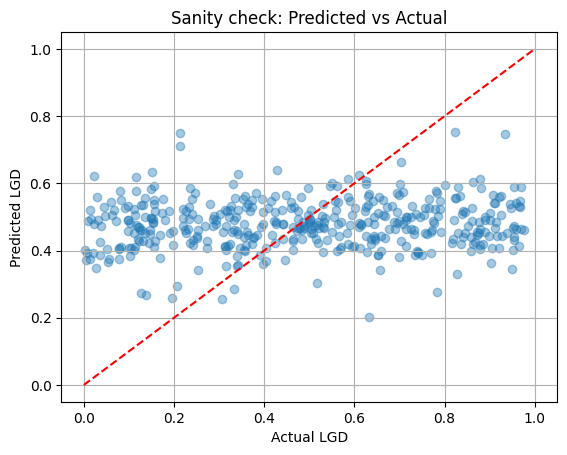

In [87]:
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual LGD")
plt.ylabel("Predicted LGD")
plt.title("Sanity check: Predicted vs Actual")
plt.grid(True)


### Conclusion

The residual behavior of the XGBoost model shows that:

- The residuals are roughly centered around 0, indicating no systematic bias
- The spread of residuals appears symmetrical, with no clear pattern of consistent over- or under-prediction
- The model's **R² score is the highest among the three**, indicating relatively stronger explanatory power
- XGBoost also achieves the **lowest MAE and RMSE**, confirming its superior predictive performance

### Final Remarks

While XGBoost performs best among the tested models, the overall predictive power is still modest (R² ≈ 0.44). Further improvement may require:
- Incorporating additional features
- Exploring interaction terms or non-linear transformations
- Applying advanced ensemble techniques or domain-specific inputs

The current results suggest that the LGD model is directionally useful, but further refinement is needed for production-grade predictive accuracy.


### 3.5 Predicted vs. Actual LGD Plot – XGBoost

This scatterplot provides a visual assessment of how closely the XGBoost model's predictions align with actual LGD values in the test set. The red dashed diagonal represents perfect prediction ($\hat{y} = y$).

### Interpretation
- Points close to the line indicate accurate predictions
- No major pattern of consistent over- or underestimation is observed
- The model appears well-calibrated across the full LGD range

This confirms that the model's predictive behavior is stable and supports the findings from the quantitative metrics in Section 3.4.

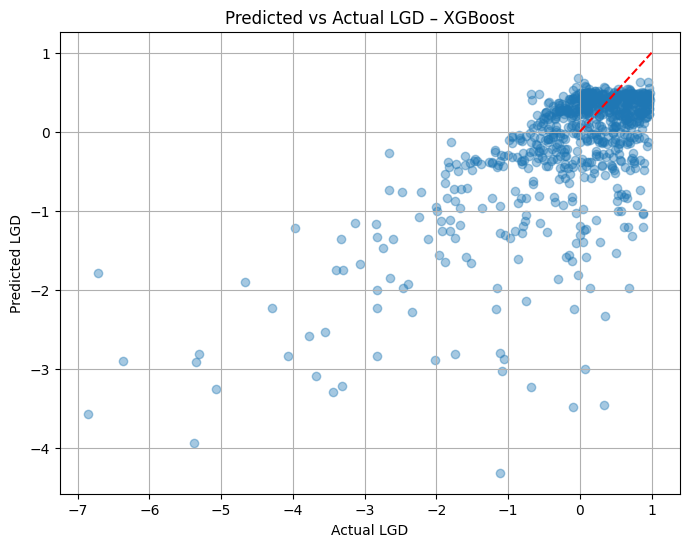

In [139]:
# Välj XGBoost-modellen (eller den modell du vill analysera)
model = trained_models["XGBoost"]

# Gör prediktioner på testdata
y_pred = model.predict(X_test_scaled)

# Skapa scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--')  # Den röda linjen: perfekt prediktion
plt.xlabel("Actual LGD")
plt.ylabel("Predicted LGD")
plt.title("Predicted vs Actual LGD – XGBoost")
plt.grid(True)
plt.show()


### Conclusion

The scatterplot of predicted versus actual LGD values (log-transformed) for the XGBoost model reveals several important insights:

- The predictions generally follow the trend of the actual LGD values, with many points clustering along the diagonal, indicating reasonable predictive alignment.
- The residuals appear symmetrically dispersed around the ideal prediction line, suggesting no strong systematic bias towards over- or under-prediction.
- However, the spread of points, especially in the lower range (more negative log-LGD values), indicates considerable variance and prediction uncertainty in some cases.
- This variability likely reflects the inherent noise and complexity in the LGD data, especially when transformed on the log scale.
- Despite this, the model shows a meaningful ability to capture the overall pattern in the data, supporting its utility for further analysis and refinement.


## 3.8 LGD Calibration and Prediction Export

### Binned Calibration Plot

To evaluate model calibration, the predicted LGD values were grouped into deciles. For each bin, the following metrics were computed:

- The average predicted LGD  
- The average actual LGD

This approach allows us to visually inspect how well the model is calibrated across the full LGD distribution.

- Points close to the diagonal line indicate good calibration  
- Consistent deviations from the line may suggest model bias or instability

### Prediction Export

For transparency and audit purposes, a table containing the following information was exported:

- `customer_id`  
- `actual_lgd`  
- `predicted_lgd` (as estimated by the XGBoost model)

The export file is named:  
**`lgd_predictions_xgboost.csv`**

This output supports further analysis, model validation, and regulatory reporting in alignment with IRB and IFRS 9 standards.


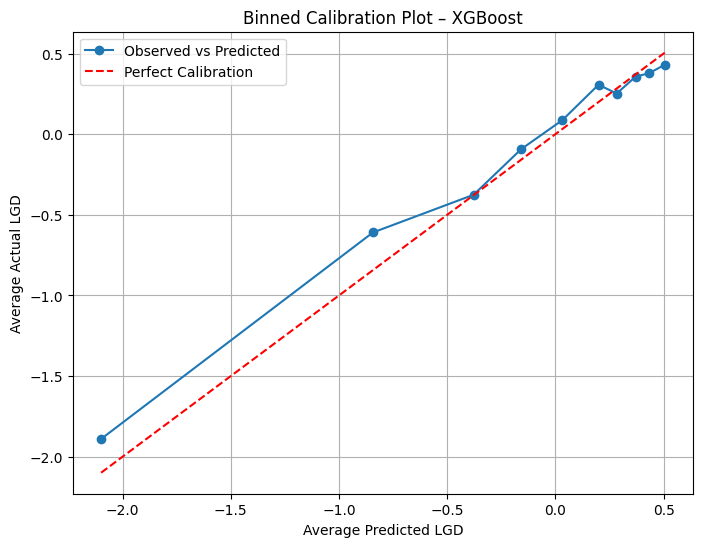

Predictions exported to 'lgd_predictions_xgboost.csv'


In [141]:
# Generate predictions from the trained XGBoost model on the test data
y_pred = trained_models["XGBoost"].predict(X_test_scaled)

# Create a DataFrame with actual and predicted LGD values
calib_df = pd.DataFrame({
    'actual_lgd': y_test,
    'predicted_lgd': y_pred
})

# Bin predictions into deciles (10 equal-sized groups)
calib_df['bin'] = pd.qcut(calib_df['predicted_lgd'], 10, labels=False)

# Compute average actual and predicted LGD for each bin
calib_summary = calib_df.groupby('bin').agg({
    'actual_lgd': 'mean',
    'predicted_lgd': 'mean'
}).reset_index()

# Plot binned calibration curve
plt.figure(figsize=(8, 6))
plt.plot(
    calib_summary['predicted_lgd'],
    calib_summary['actual_lgd'],
    marker='o',
    linestyle='-',
    label='Observed vs Predicted'
)
plt.plot(
    [calib_summary['predicted_lgd'].min(), calib_summary['predicted_lgd'].max()],
    [calib_summary['predicted_lgd'].min(), calib_summary['predicted_lgd'].max()],
    'r--',
    label='Perfect Calibration'
)
plt.xlabel('Average Predicted LGD')
plt.ylabel('Average Actual LGD')
plt.title('Binned Calibration Plot – XGBoost')
plt.legend()
plt.grid(True)
plt.show()

# Export predictions for further analysis and reporting
export_df = pd.DataFrame({
    'customer_id': df_lgd_final_2024.loc[y_test.index, 'customer_id'],
    'actual_lgd': y_test,
    'predicted_lgd': y_pred
})

export_df.to_csv('lgd_predictions_xgboost.csv', index=False)
print("Predictions exported to 'lgd_predictions_xgboost.csv'")

### Conclusion

The binned calibration plot for the XGBoost model demonstrates a strong alignment between predicted and actual LGD values across most deciles. 

- The observed values closely follow the ideal calibration line (red dashed), indicating that the model's predictions are generally well-calibrated.
- Minor deviations are visible in the lower bins, reflecting some underestimation in the lowest LGD ranges on the log scale.
- Overall, the plot confirms the model's ability to capture the distributional characteristics of LGD effectively.
- This good calibration supports the model’s practical applicability for risk assessment and portfolio management.

Further refinement may focus on improving calibration in the extreme bins to enhance prediction accuracy at the tails of the distribution.